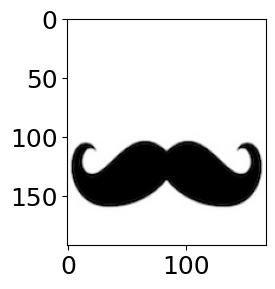

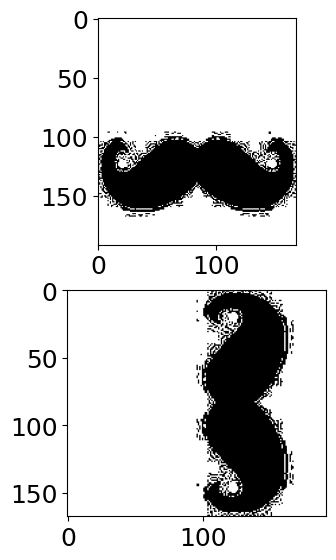

In [64]:
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.io
from sklearn import linear_model
from sklearn import model_selection
from scipy.optimize import minimize
from skimage.transform import resize
from matplotlib.image import imread

# setting plotting parameters
plt.rcParams['figure.figsize'] = [7, 7]
plt.rcParams.update({'font.size': 18})

# loading mustache image
mustache = imread(os.path.join('..','DATA','mustache.jpg'))

plt.figure(figsize=(5,10))
plt.subplot(3,1,1)
plt.imshow(mustache,plt.cm.gray)

mustache = np.mean(mustache, -1); # Convert RGB to grayscale
mustache = (mustache/255).astype(int) 
# Normalize the image. When pixel values are scaled to a range of 0 and 1, 
# the image data is easier to work with because the values are small.
# And ensuring consistency ehrn performing calculations

plt.figure(figsize=(5,10))
plt.subplot(3,1,2)
plt.imshow(mustache,plt.cm.gray)


mustache = mustache.T.copy() # this library might put the image in transposed form.

plt.subplot(3,1,3)
plt.imshow(mustache,plt.cm.gray)




In [65]:
# loading faces data
mat = scipy.io.loadmat(os.path.join('..','DATA','allFaces.mat')) # load data from matlab file
print(mat.keys())


dict_keys(['__header__', '__version__', '__globals__', 'faces', 'n', 'm', 'sub', 'nfaces', 'person'])


In [66]:
X = mat['faces'] # that matlab file contain a variable named 'faces'
# there is totally 38 people, each people has around 62~64 images. 

print(f"X size: {X.shape}")

nfaces = mat['nfaces'].reshape(-1) # that matlab also contain a varialbe named 'nfaces'

print(f"nface: size = {nfaces.shape}, data = {nfaces}, cumsum: {np.cumsum(nfaces)}")

nperson = mat['person']
print(nperson.shape)

n = mat['n'] # that matlab also contain a varialbe named 'n'
m = mat['m']
print(f"shape of nperson, n, m :{nperson.shape},{n.shape}, {m.shape}")
n = int(n)
m = int(m)
print(n)
print(m)

X size: (32256, 2410)
nface: size = (38,), data = [64 62 64 64 62 64 64 64 64 64 60 59 60 63 62 63 63 64 64 64 64 64 64 64
 64 64 64 64 64 64 64 64 64 64 64 64 64 64], cumsum: [  64  126  190  254  316  380  444  508  572  636  696  755  815  878
  940 1003 1066 1130 1194 1258 1322 1386 1450 1514 1578 1642 1706 1770
 1834 1898 1962 2026 2090 2154 2218 2282 2346 2410]
(1, 1)
shape of nperson, n, m :(1, 1),(1, 1), (1, 1)
192
168


C:\Users\kinla\AppData\Local\Temp\ipykernel_9628\2201951648.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  n = int(n)
C:\Users\kinla\AppData\Local\Temp\ipykernel_9628\2201951648.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  m = int(m)


In [67]:
## Build Training and Test sets
nTrain = 30
nTest = 20
nPeople = 20

Train = np.zeros((X.shape[0],nTrain*nPeople)) 
# X.shape[0] = 32256, the size of each image. col: the number of training images
Test = np.zeros((X.shape[0],nTest*nPeople))

# downsmaple training images to build \Theta library
for k in range(nPeople):
    baseind = 0 # this will be keep track of the starting index of the curret person's image.
    if k > 0:
        baseind = np.sum(nfaces[:k]) 
        # setting up the base index
        # if k > 0, it calculates the cummulattive sum of nfaces from 0 to k-1.
    inds = range(baseind,baseind+nfaces[k], 1)
    # create a range that we will insert images 
    
    # Below part reconstructing Train set
    Train[:,k*nTrain:(k+1)*nTrain] = X[:,inds[:nTrain]]
    # X[:,inds[:nTrain]: it means select columns baseind ~ baseind+nTrain-1 of X
    # select all rows, and 
    
    # We use similar method to construct Test set
    Test[:,k*nTest:(k+1)*nTest] = X[:,inds[nTrain:(nTrain+nTest)]]

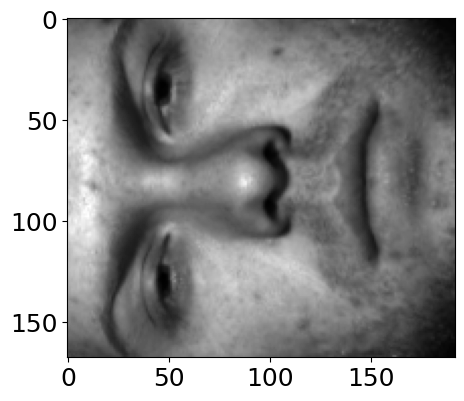

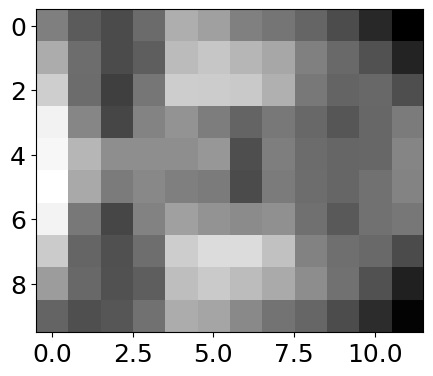

In [86]:
## Downsample Training Images (Build Theta)
M = Train.shape[1] 
# number of columns = number of training images
# M = 600

Theta = np.zeros((120,M)) 
# create an empty matrix with 120 rows and M columns
# Theta is the library of training images.

plt.figure(figsize=(5,10))
plt.subplot(2,1,1)
plt.imshow(np.reshape(Train[:,1],(168,192)) ,plt.cm.gray) # show the 2nd training image before processing

Train[:,1]
# processing the training images
# iterate through each training example. 
for k in range(M):
    temp = np.reshape(np.copy(Train[:,k]),(m,n)) 
    # np.copy(Train[:,k]) means copy the kth column of Train = the k+1th training image
    # m,n is the default size of each image. m=192, n=168
    # M.shape[0] = 32256, which shows it is matching m and n.
    
    tempSmall = resize(temp, (10, 12), anti_aliasing=True) # anti aliasing only works for 2D images. 
    """
    plt.figure(figsize=(5,10))
    plt.subplot(3,1,2)
    plt.imshow(tempSmall,plt.cm.gray)
    """
    Theta[:,k] = tempSmall.reshape(-1)

plt.figure(figsize=(5,10))
plt.subplot(2,1,2)
plt.imshow(np.reshape(Theta[:,1],(10,12)) ,plt.cm.gray)

In [69]:
## Renormalize Columns of Theta
normTheta = np.zeros(M)
for k in range(M):
    normTheta[k] = np.linalg.norm(Theta[:,k])
    Theta[:,k] = Theta[:,k]/normTheta[k]

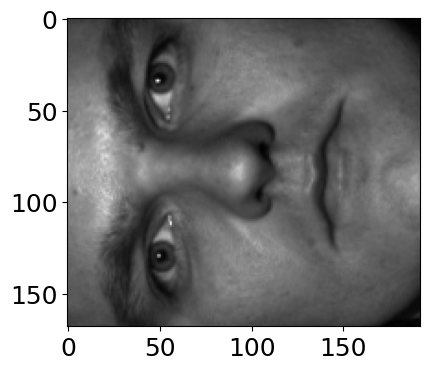

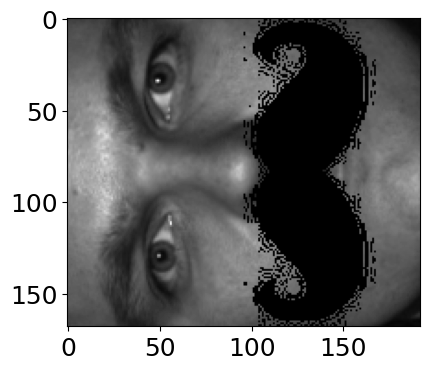

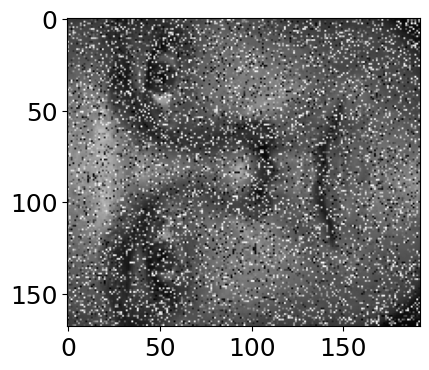

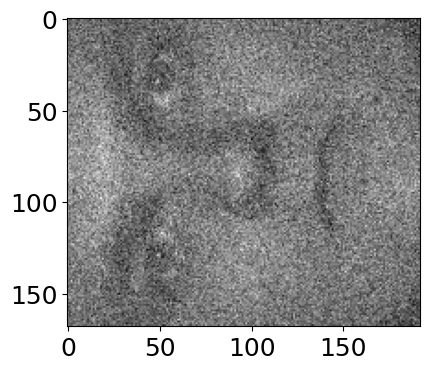

In [88]:
# in this section, the code is manipulating test images for further analysis.

## Occlude (alter) Test Image (Test[:,125] = test image 6, person 7)
# build tet images and downsample to obtain y
x1 = np.copy(Test[:,125]) # Clean image indexed at 125. It is the original, unaltered test image. 
x2 = np.copy(Test[:,125]) * mustache.reshape(n*m) # This multiplication overlay the mustache on the test image.

randvec = np.random.permutation(n*m)
# this generates a random permutation of integers from range. 
first30 = randvec[:int(np.floor(0.3*len(randvec)))]
# this selects first 30% of random permuted indices. 
vals30 = (255*np.random.rand(*first30.shape)).astype(int)
# This line generates random integer values between 0 and 255 to occlude the selected pixels. 
# The shape of vals30 matches the shape of first30.
x3 = np.copy(x1)
x3[first30] = vals30 # 30% occluded
x4 = np.copy(x1) + 50*np.random.randn(*x1.shape) # Random noise

plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(np.reshape(x1,(168,192)) ,plt.cm.gray)
plt.figure(figsize=(10,10))
plt.subplot(2,2,2)
plt.imshow(np.reshape(x2,(168,192)) ,plt.cm.gray)
plt.figure(figsize=(10,10))
plt.subplot(2,2,3)
plt.imshow(np.reshape(x3,(168,192)) ,plt.cm.gray)
plt.figure(figsize=(10,10))
plt.subplot(2,2,4)
plt.imshow(np.reshape(x4,(168,192)) ,plt.cm.gray)

In [71]:
#Q: why we need to put all test images into a collection
# X is the collection of 4 test images
X = np.zeros((x1.shape[0],4))
X[:,0] = x1
X[:,1] = x2
X[:,2] = x3
X[:,3] = x4

## Downsample Test Images
# Y is the collection of 4 downsized test images
Y = np.zeros((120,4))
for k in range(4):
    temp = np.reshape(np.copy(X[:,k]),(m,n))
    tempSmall = resize(temp, (10, 12), anti_aliasing=True)
    Y[:,k] = tempSmall.reshape(-1)

In [72]:
## L1 Search, Testclean
y1 = np.copy(Y[:,0])
eps = 0.01

# L1 Minimum norm solution s_L1
def L1_norm(x):
    return np.linalg.norm(x,ord=1)

constr = ({'type': 'ineq', 'fun': lambda x:  eps - np.linalg.norm(Theta @ x - y1,2)})
x0 = np.linalg.pinv(Theta) @ y1 # initialize with L2 solution
res = minimize(L1_norm, x0, method='SLSQP',constraints=constr)
s1 = res.x

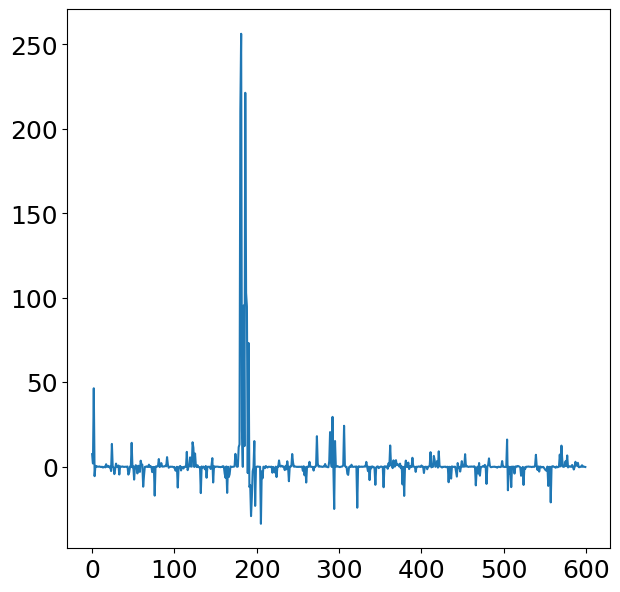

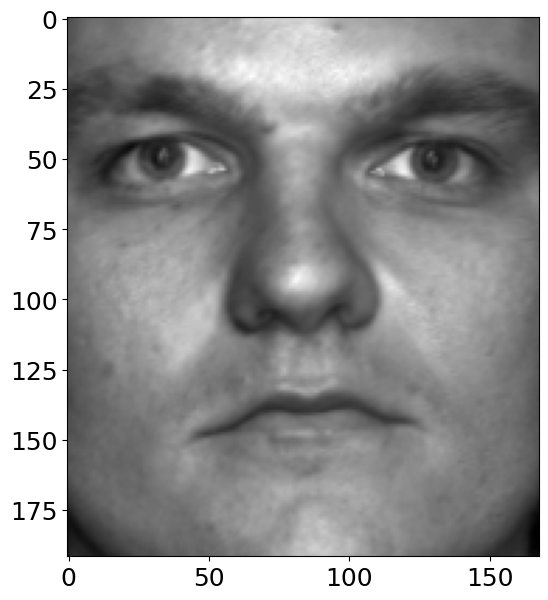

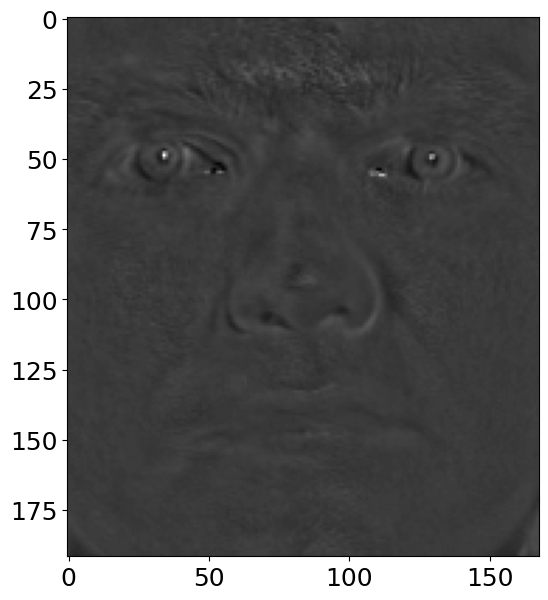

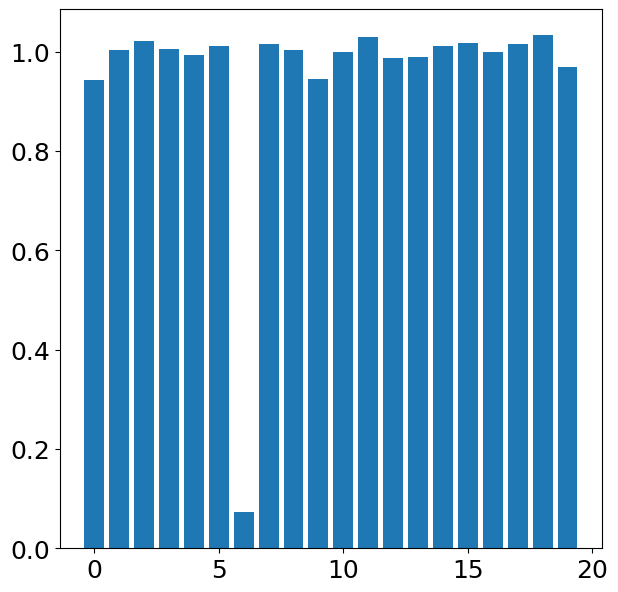

In [73]:
plt.figure()
plt.plot(s1)
plt.figure()
plt.imshow(np.reshape(Train @ (s1/normTheta),(m,n)).T,cmap='gray')
plt.figure()
plt.imshow(np.reshape(x1 - Train @ (s1/normTheta),(m,n)).T,cmap='gray')

binErr = np.zeros(nPeople)
for k in range(nPeople):
    L = range(k*nTrain,(k+1)*nTrain)
    binErr[k] = np.linalg.norm(x1-Train[:,L] @ (s1[L]/normTheta[L]))/np.linalg.norm(x1)
    
plt.figure()
plt.bar(range(nPeople),binErr)
plt.show()


In [74]:
# Do the test for the second test image

## L1 Search, Mustache
y2 = np.copy(Y[:,1])
eps = 500

# L1 Minimum norm solution s_L1
def L1_norm(x):
    return np.linalg.norm(x,ord=1)

constr = ({'type': 'ineq', 'fun': lambda x:  eps - np.linalg.norm(Theta @ x - y2,2)})
x0 = np.linalg.pinv(Theta) @ y2 # initialize with L2 solution
res = minimize(L1_norm, x0, method='SLSQP',constraints=constr)
s2 = res.x

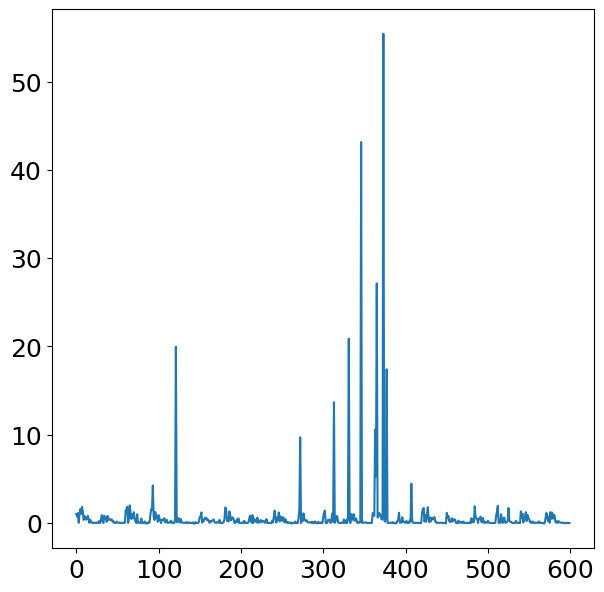

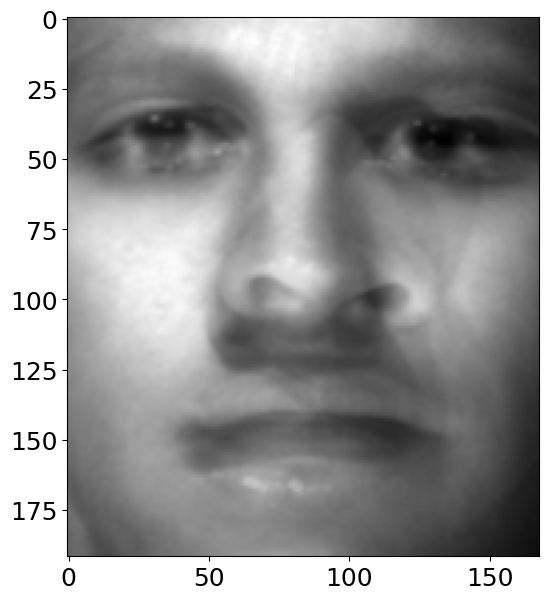

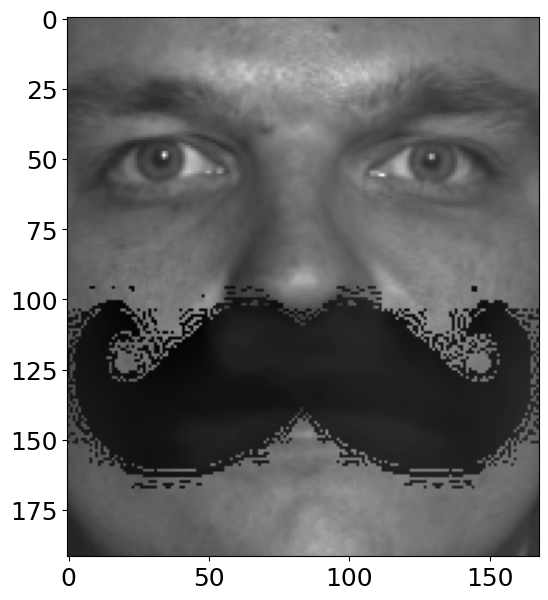

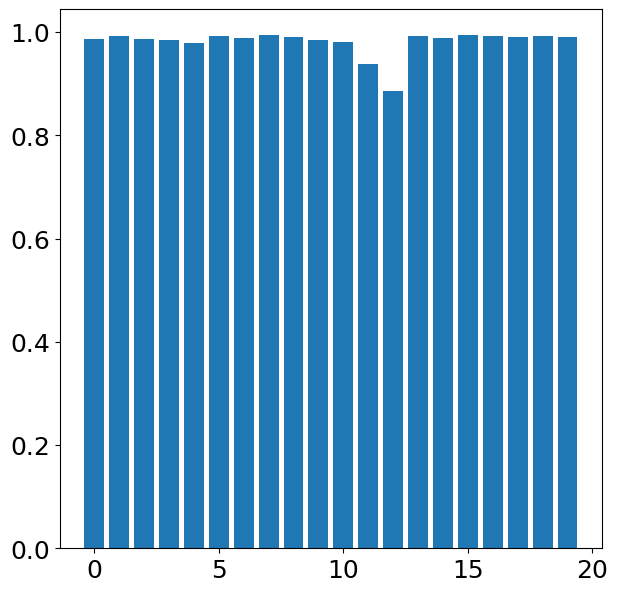

In [75]:
plt.figure()
plt.plot(s2)
plt.figure()
plt.imshow(np.reshape(Train @ (s2/normTheta),(m,n)).T,cmap='gray')
plt.figure()
plt.imshow(np.reshape(x2 - Train @ (s2/normTheta),(m,n)).T,cmap='gray')

binErr = np.zeros(nPeople)
for k in range(nPeople):
    L = range(k*nTrain,(k+1)*nTrain)
    binErr[k] = np.linalg.norm(x2-Train[:,L] @ (s2[L]/normTheta[L]))/np.linalg.norm(x2)
    
plt.figure()
plt.bar(range(nPeople),binErr)
plt.show()

In [76]:
# Do the test for the third person

## L1 Search, Occlusion
y3 = np.copy(Y[:,2])
eps = 1000

# L1 Minimum norm solution s_L1
def L1_norm(x):
    return np.linalg.norm(x,ord=1)

constr = ({'type': 'ineq', 'fun': lambda x:  eps - np.linalg.norm(Theta @ x - y3,2)})
x0 = np.linalg.pinv(Theta) @ y3 # initialize with L2 solution
res = minimize(L1_norm, x0, method='SLSQP',constraints=constr)
s3 = res.x

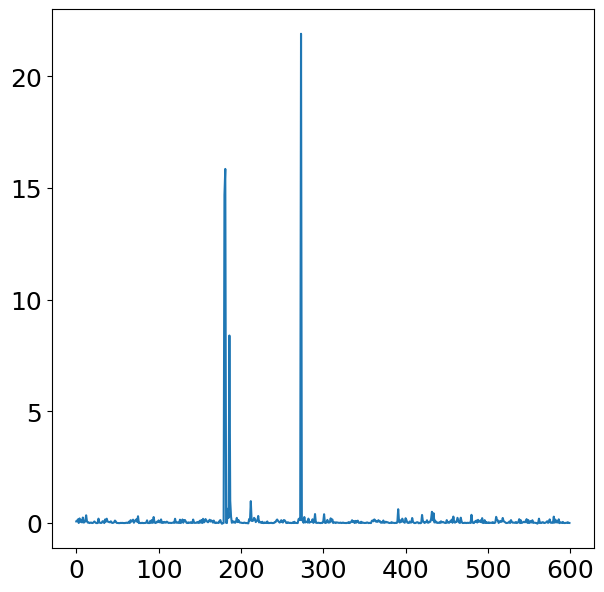

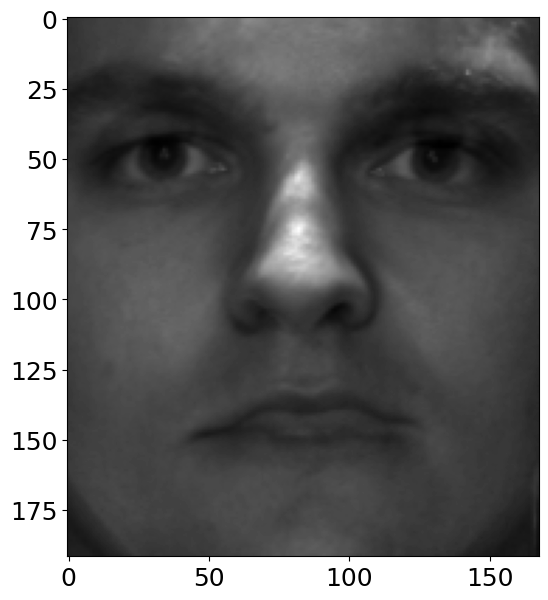

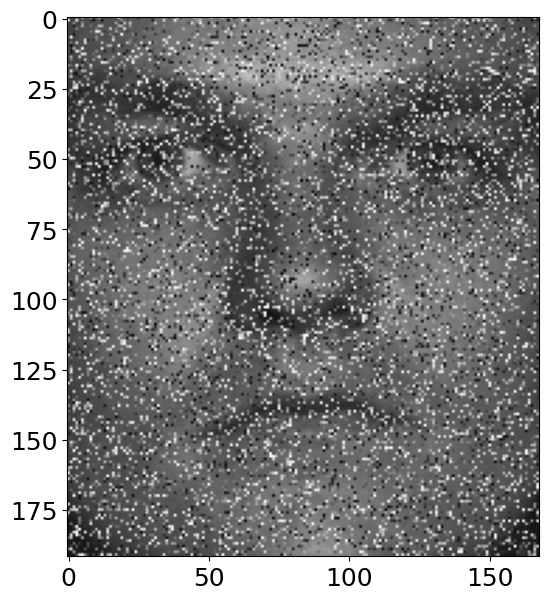

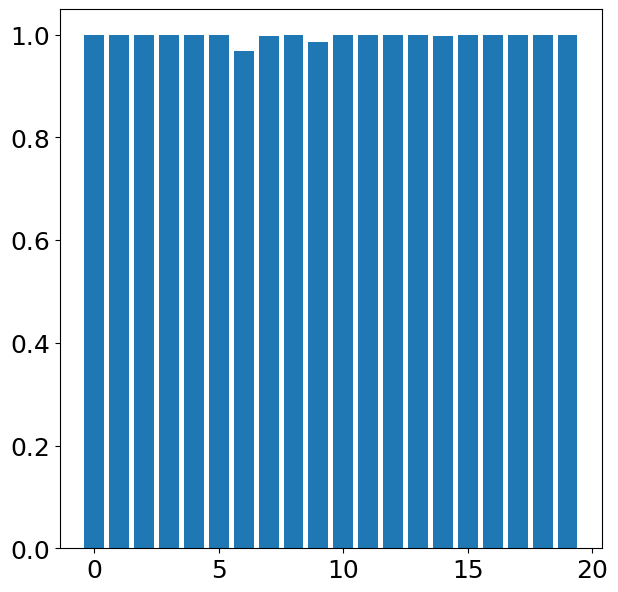

In [77]:
plt.figure()
plt.plot(s3)
plt.figure()
plt.imshow(np.reshape(Train @ (s3/normTheta),(m,n)).T,cmap='gray')
plt.figure()
plt.imshow(np.reshape(x3 - Train @ (s3/normTheta),(m,n)).T,cmap='gray')

binErr = np.zeros(nPeople)
for k in range(nPeople):
    L = range(k*nTrain,(k+1)*nTrain)
    binErr[k] = np.linalg.norm(x3-Train[:,L] @ (s3[L]/normTheta[L]))/np.linalg.norm(x3)
    
plt.figure()
plt.bar(range(nPeople),binErr)
plt.show()

In [78]:
## L1 Search, Noise
y4 = np.copy(Y[:,3])
eps = 10

# L1 Minimum norm solution s_L1
def L1_norm(x):
    return np.linalg.norm(x,ord=1)

constr = ({'type': 'ineq', 'fun': lambda x:  eps - np.linalg.norm(Theta @ x - y4,2)})
x0 = np.linalg.pinv(Theta) @ y4 # initialize with L2 solution
res = minimize(L1_norm, x0, method='SLSQP',constraints=constr)
s4 = res.x

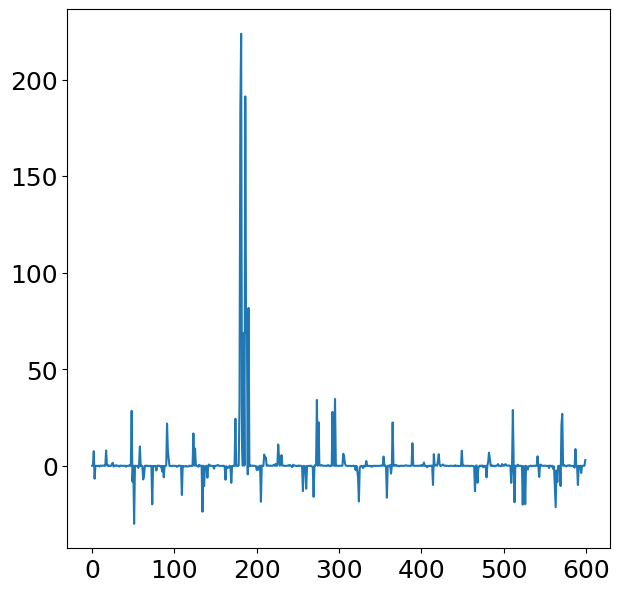

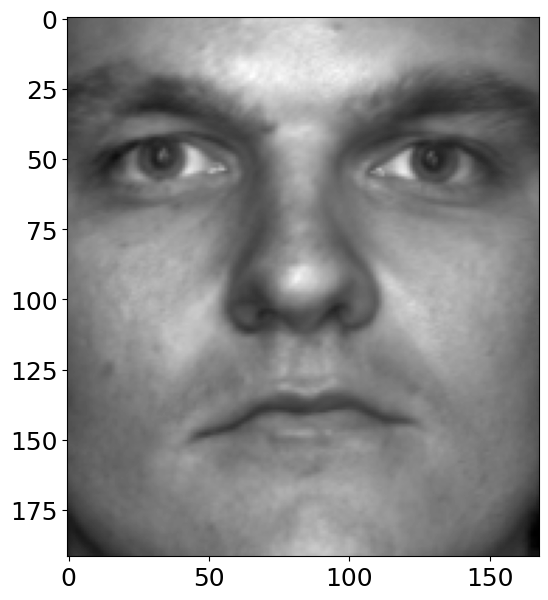

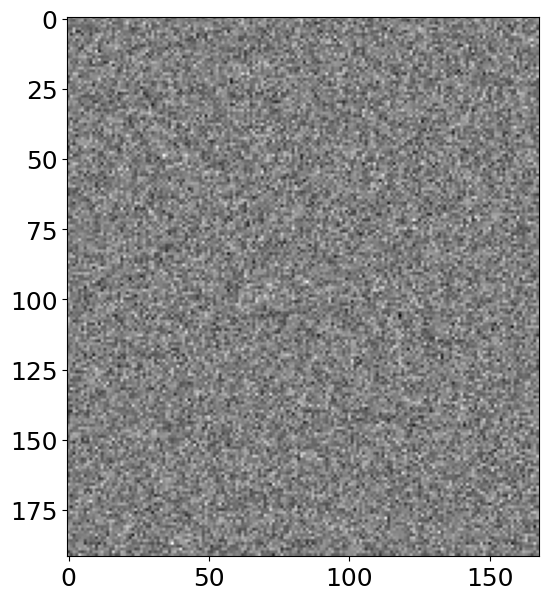

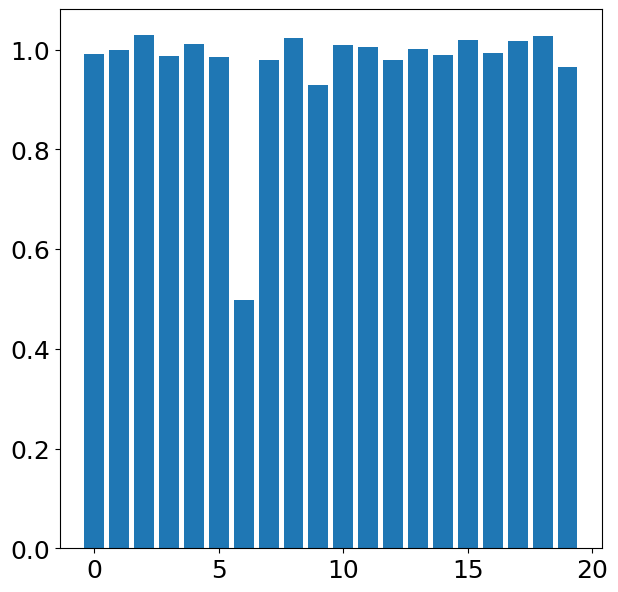

In [79]:
plt.figure()
plt.plot(s4)
plt.figure()
plt.imshow(np.reshape(Train @ (s4/normTheta),(m,n)).T,cmap='gray')
plt.figure()
plt.imshow(np.reshape(x4 - Train @ (s4/normTheta),(m,n)).T,cmap='gray')

binErr = np.zeros(nPeople)
for k in range(nPeople):
    L = range(k*nTrain,(k+1)*nTrain)
    binErr[k] = np.linalg.norm(x4-Train[:,L] @ (s4[L]/normTheta[L]))/np.linalg.norm(x4)
    
plt.figure()
plt.bar(range(nPeople),binErr)
plt.show()

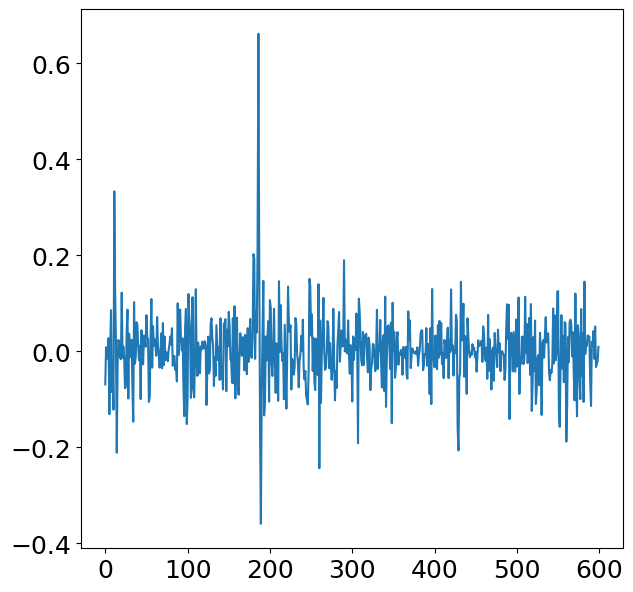

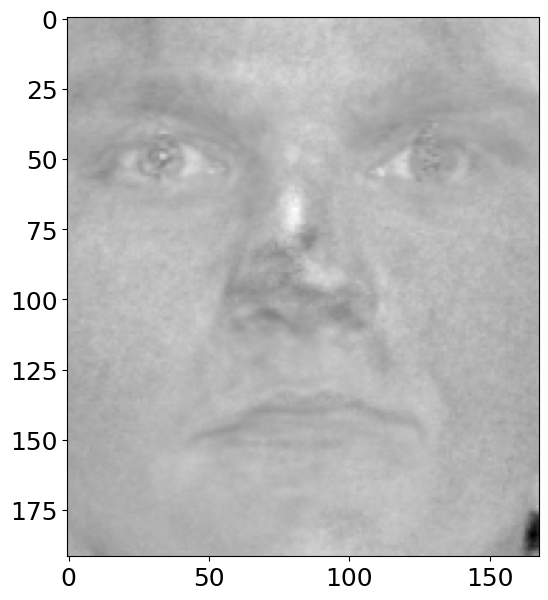

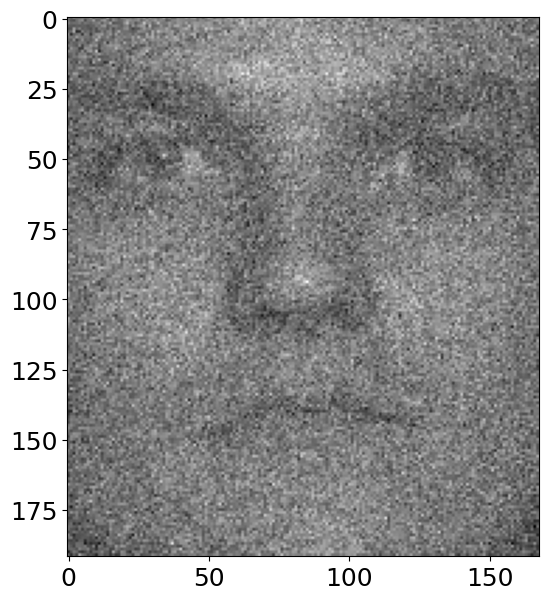

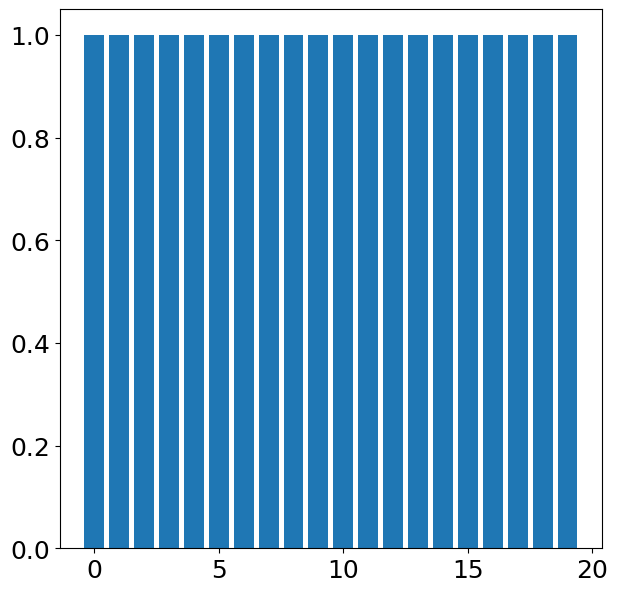

In [80]:
## Least Squares Is No Good
s4L2 = np.linalg.pinv(Train) @ x4
plt.figure()
plt.plot(s4L2)
plt.figure()
plt.imshow(np.reshape(Train @ (s4L2/normTheta),(m,n)).T,cmap='gray')
plt.figure()
plt.imshow(np.reshape(x4 - Train @ (s4L2/normTheta),(m,n)).T,cmap='gray')

binErr = np.zeros(nPeople)
for k in range(nPeople):
    L = range(k*nTrain,(k+1)*nTrain)
    binErr[k] = np.linalg.norm(x4-Train[:,L] @ (s4L2[L]/normTheta[L]))/np.linalg.norm(x4)
    
plt.figure()
plt.bar(range(nPeople),binErr)
plt.show()